# Section 1: Accessing Database

In [4]:
import pymysql
import pandas as pd
import numpy as np

#Connect to MySQL database

cnx = pymysql.connect(user='buspark', password='U@5p1r3!',
                              host='masscourtsplus.org',
                              database='wp_courtdocs')


cursor = cnx.cursor()
# more info here: https://docs.google.com/document/d/1aZKF0X7HjcXUYurD8uQYDpgo9wQdeJH4CMviBJeTYVc/edit#


# Section 2: Debt Collection Cases/Pro Se analysis

Pro se is sometimes referred to as pro per (pro se) in the attorney list because different court systems refer to defending yourself without an attorney as pro se or pro per. In the US, especially in Massachusetts, pro se and pro per are used interchangeably. For this reason, I had my conde replace "Pro Per (Pro Se)" as just Pro Se because they are the same categorya anyways.

In [5]:
query = """
SELECT
    case_number,
    case_type,
    case_status,
    CASE 
        WHEN post_title = 'Pro Se (PROPER)' THEN 'Pro Se'
        ELSE post_title
    END AS attorney
FROM
    cdocs_case_meta_index AS cdocs_meta
        JOIN
    wp_terms ON wp_terms.term_id = cdocs_meta.court_term_id
        JOIN
    wp_term_taxonomy ON wp_term_taxonomy.term_id = cdocs_meta.court_term_id
        JOIN
    wp_terms t1 ON t1.term_id = wp_term_taxonomy.parent
		JOIN
    cdocs_party_assignment_index party_aidx ON party_aidx.case_id = cdocs_meta.post_id
    		JOIN
    wp_posts ON wp_posts.id = party_aidx.attorney_id
    		JOIN
    cdocs_case_action_index action_idx ON action_idx.case_id = party_aidx.case_id
WHERE
    action_idx.description LIKE '%debt%'
;

"""

%time

cursor.execute(query)
results = cursor.fetchall()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs


The code generates a data table of all debt cases. However, the case numbers are not unique because the data did not fit all the information in one line. Prominent dates and actions are recorded in the description column. If there is more than one description related to the case, then there will be two dedicated rows to that case. This is why 1107SC000552 has two repeated rows(rows 2 and 3).

In [39]:
debt_cases = pd.DataFrame(results).rename({0: 'Case Number',1: 'Case Type',2: 'Status',3: 'Attorney'}, axis = 1)
debt_cases_unique=debt_cases.drop_duplicates(subset=['Case Number']);
debt_cases


,Case Number,Case Type,Status,Attorney
0,1107SC000560,Small Claims,Disposed (Statistical Purposes),"Wilson, Kenneth C"
1,1107SC000554,Small Claims,Disposed (Statistical Purposes),"Cox, Aaron"
2,1107SC000552,Small Claims,Disposed (Statistical Purposes),"O'Brien, Jr., Lawrence E"
3,1107SC000552,Small Claims,Disposed (Statistical Purposes),"O'Brien, Jr., Lawrence E"
4,1107SC000552,Small Claims,Disposed (Statistical Purposes),"O'Brien, Jr., Lawrence E"
...,...,...,...,...
1705222,2413CV000384,Civil,Open,"Reczek, Erin M"
1705223,2413CV000384,Civil,Open,"Reczek, Erin M"
1705224,2413CV000385,Civil,Open,"Reczek, Erin M"
1705225,2413CV000385,Civil,Open,"Reczek, Erin M"


In [40]:
print(f"In total, there have been {debt_cases['Case Number'].nunique()} debt cases.") 
# .nunique() to find unique case number and return total value.


In total, there have been 724294 debt cases.


Attorney
Wilson, Kenneth C          65355
Pro Se                     53129
Wiener, Stephen A.         49039
Heinold, Dean A.           38349
Kreppel, Gary Howard       35524
                           ...  
Bobb, Jessica Marie            1
Hamelburg, Gerald A            1
Ryan, Jr., Daniel R.           1
Lepper, Allison Brooke         1
Rinne, Erich S                 1
Name: count, Length: 13903, dtype: int64

Once again, there is a repeat case number problem, this time we can do the inverse by dropping duplicates.

In [41]:
prose_proper=debt_cases[debt_cases['Attorney'].isin(['Pro Se'])]
prose_proper_no_dupe=prose_proper.drop_duplicates(subset=['Case Number'])
prose_proper_no_dupe

,Case Number,Case Type,Status,Attorney
65,11H84CV000477,Housing Court Civil,Closed,Pro Se
66,11H84CV000478,Housing Court Civil,Closed,Pro Se
75,11H84SP002242,Housing Court Summary Process,Closed,Pro Se
77,11H84SP002243,Housing Court Summary Process,Active,Pro Se
80,11H84SP002244,Housing Court Summary Process,Active,Pro Se
...,...,...,...,...
1705144,23H77SP001820,Housing Court Summary Process,Active,Pro Se
1705149,23H77SP001821,Housing Court Summary Process,Active,Pro Se
1705153,23H77SP001822,Housing Court Summary Process,Active,Pro Se
1705156,23H77SP001823,Housing Court Summary Process,Active,Pro Se


Returns true if the number of rows(cases) in the unique prose_proper table is the same as the number of rows(cases) in the prose_proper_no_dupe table.

In [11]:
prose_proper['Case Number'].nunique()==len(prose_proper_no_dupe['Case Number'])

True

In [12]:
total_prose_debt_cases = prose_proper_no_dupe['Case Number'].nunique() #returns same table above because prose_proper_no_dupe arey has no duplicate values.

print(f"Total count of (unique) pro se cases in prose_proper_no_dupe : {total_prose_debt_cases}.\n"
      f"Unique case numbers in prose_proper is {prose_proper['Case Number'].nunique()}.\n"
      f"Number of rows in first column of prose_proper_no_dupe: {len(prose_proper_no_dupe['Case Number'])}.\n")



status_counts_prose_pp = prose_proper_no_dupe['Status'].value_counts()
status_counts_prose_pp=status_counts_prose_pp.to_dict()
print('Count of pro se cases by status')
print("\n".join(f"{status}: {count}" for status, count in status_counts_prose_pp.items()))



Total count of (unique) pro se cases in prose_proper_no_dupe : 145177.
Unique case numbers in prose_proper is 145177.
Number of rows in first column of prose_proper_no_dupe: 145177.

Count of pro se cases by status
Active: 84161
Closed: 59817
Open: 327
Reopened: 285
Disposed (Statistical Purposes): 270
Suspended COVID19 - TBD: 236
Suspended-Covid-19: 67
Suspended-notices sent Covid-19: 12
Suspended: 2


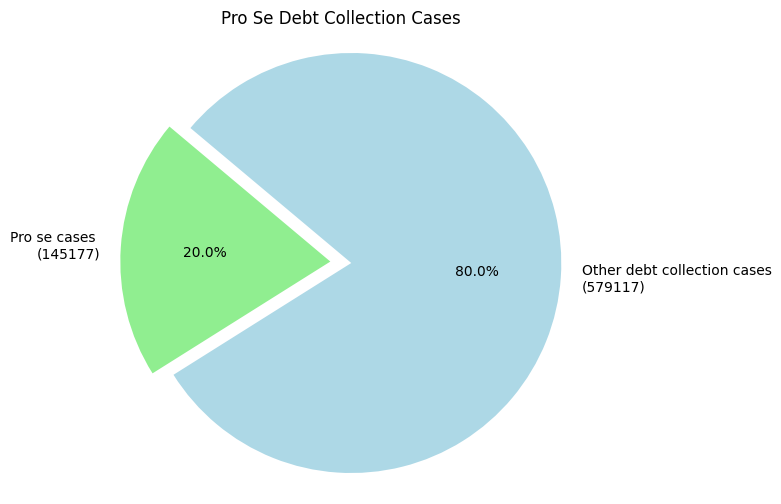

In [14]:
import matplotlib.pyplot as plt

debt_cases_unique #Total Debt cases
total_prose_debt_cases #Total of Debt cases that are pro se

# Calculate the percentage of debt cases that are Pro Se
percentage_prose = (total_prose_debt_cases / debt_count) * 100
percentage_other = 100 - percentage_prose

# Data for the pie chart
labels = ['Pro se cases \n({})'.format(total_prose_debt_cases), 'Other debt collection cases\n({})'.format(debt_count - total_prose_debt_cases)]
sizes = [percentage_prose, percentage_other]



colors = ['lightgreen','lightblue']

# Plotting the pie chart
explode = (0.1, 0)
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=explode)
plt.title('Pro Se Debt Collection Cases')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


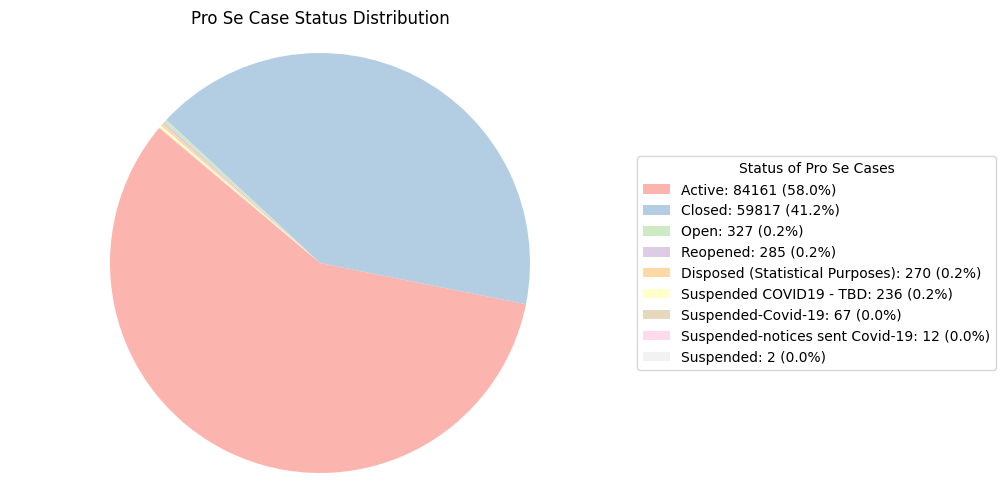

In [15]:
import matplotlib.pyplot as plt
status_counts_prose_pp;

# Pie Chart
pro_se_status_labels = list(status_counts_prose_pp.keys())
pro_se_status_sizes = list(status_counts_prose_pp.values())
pro_se_total_cases = sum(pro_se_status_sizes)  # Total number of cases for percentage calculation
pro_se_colors = plt.cm.Pastel1(range(len(pro_se_status_labels)))  # Generate color palette

# Create percentage labels for the legend with new variable names
pro_se_percentages = [f"{(size/pro_se_total_cases)*100:.1f}%" for size in pro_se_status_sizes]
pro_se_legend_labels = [f"{label}: {size} ({percent})" for label, size, percent in zip(pro_se_status_labels, pro_se_status_sizes, pro_se_percentages)]

# Plotting the pie chart with new variable names
plt.figure(figsize=(8, 6))
pro_se_wedges, pro_se_texts = plt.pie(pro_se_status_sizes, colors=pro_se_colors, startangle=140)

# Adding a legend outside the plot on the right side with updated variable names
plt.legend(pro_se_wedges, pro_se_legend_labels, title="Status of Pro Se Cases", loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Pro Se Case Status Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

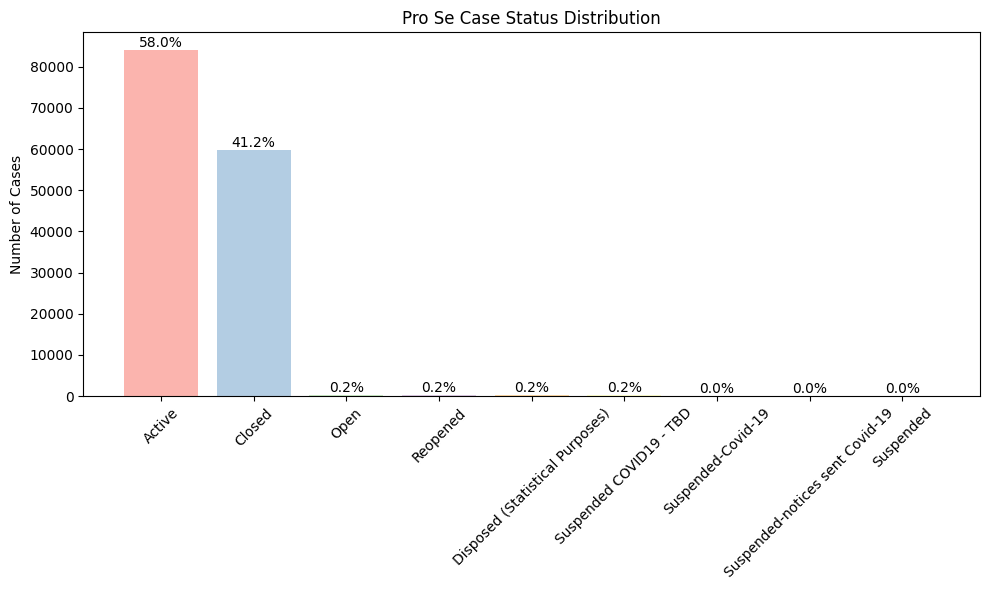

In [17]:
# Bar Graph
pro_se_status_labels = list(status_counts_prose_pp.keys())
pro_se_status_sizes = list(status_counts_prose_pp.values())
pro_se_total_cases = sum(pro_se_status_sizes)  # Total number of cases for percentage calculation
pro_se_colors = plt.cm.Pastel1(range(len(pro_se_status_labels)))  # Generate color palette

# Create percentage labels for the legend with new variable names
pro_se_percentages = [f"{(size/pro_se_total_cases)*100:.1f}%" for size in pro_se_status_sizes]
pro_se_legend_labels = [f"{label}: {size} ({percent})" for label, size, percent in zip(pro_se_status_labels, pro_se_status_sizes, pro_se_percentages)]

# Plotting the bar graph with new variable names
plt.figure(figsize=(10, 6))
bars = plt.bar(pro_se_status_labels, pro_se_status_sizes, color=pro_se_colors)

# Adding value labels above each bar
for bar, label in zip(bars, pro_se_percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, label, ha='center', va='bottom')

plt.title('Pro Se Case Status Distribution')
plt.xlabel('')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.tight_layout()  # Adjust layout to make room for the rotated labels

plt.show()

In [32]:
pro_se_status_sizes[1]
debt_cases_unique_no_prose=debt_cases_unique[debt_cases_unique['Attorney'] != 'Pro Se']

status_counts_debt_no_prose = debt_cases_unique_no_prose['Status'].value_counts()
status_counts_debt_no_prose=status_counts_debt_no_prose.to_dict()

In [34]:
len(debt_cases_unique_no_prose)

,Case Number,Case Type,Status,Attorney
0,1107SC000560,Small Claims,Disposed (Statistical Purposes),"Wilson, Kenneth C"
1,1107SC000554,Small Claims,Disposed (Statistical Purposes),"Cox, Aaron"
2,1107SC000552,Small Claims,Disposed (Statistical Purposes),"O'Brien, Jr., Lawrence E"
5,1107SC000551,Small Claims,Disposed (Statistical Purposes),"O'Brien, Jr., Lawrence E"
6,1107SC000546,Small Claims,Disposed (Statistical Purposes),"Cox, Aaron"
...,...,...,...,...
1705212,2413CV000381,Civil,Open,"Reczek, Erin M"
1705215,2413CV000382,Civil,Open,"Reczek, Erin M"
1705218,2413CV000383,Civil,Open,"Reczek, Erin M"
1705221,2413CV000384,Civil,Open,"Reczek, Erin M"


In [ ]:
import matplotlib.pyplot as plt
pro_se_status_sizes;
debt_cases_unique
debt_cases_unique=debt_cases.drop_duplicates(subset=['Case Number']);
debt_cases_unique[debt_cases_unique['Status'].isin(['Active'])]

# Calculate the total number of case

# Create labels for the pie chart
labels = ['Active Debt collection Cases\n{} ({:.1f}%)'.format(pro_se_status_sizes[1], pro_se_status_sizes[1] / total_cases * 100),
          'Active pro se cases\n{} ({:.1f}%)'.format(unique_Prose_, unique_Prose_ / total_cases * 100)]

# Create sizes for the pie chart
sizes = [pro_se_status_sizes[1], unique_Prose_]

# Define colors
colors = ['blue', 'green']

# Create a pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Add a title
plt.title('Active Debt Collection Cases that are Pro Se')

# Show the pie chart
plt.show()


# Section 3: Default,Judgement Cases

In [ ]:
query = """
SELECT
    case_number,
    case_type,
    case_status,
    CASE 
        WHEN post_title = 'Pro Se (PROPER)' THEN 'Pro Se'
        ELSE post_title
    END AS attorney
FROM
    cdocs_case_meta_index AS cdocs_meta
        JOIN
    wp_terms ON wp_terms.term_id = cdocs_meta.court_term_id
        JOIN
    wp_term_taxonomy ON wp_term_taxonomy.term_id = cdocs_meta.court_term_id
        JOIN
    wp_terms t1 ON t1.term_id = wp_term_taxonomy.parent
        JOIN
    cdocs_party_assignment_index party_aidx ON party_aidx.case_id = cdocs_meta.post_id
            JOIN
    wp_posts ON wp_posts.id = party_aidx.attorney_id
            JOIN
    cdocs_case_action_index action_idx ON action_idx.case_id = party_aidx.case_id
WHERE
    action_idx.description LIKE '%debt%'
    AND action_idx.description LIKE '%default%'
    AND action_idx.description LIKE '%judgement%'
"""

%time

cursor.execute(query)
results = cursor.fetchall()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8df5a09c-22d6-4edb-b49b-1a2367b8b2ae' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>